In [1]:
import numpy as np
import pandas as pd

In [2]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_auc_score, precision_score,\
        recall_score, classification_report, precision_recall_curve,\
        confusion_matrix, auc, roc_curve

In [3]:
from lightgbm import LGBMClassifier
import lightgbm
import  catboost as catb
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

In [4]:
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#from sklearn.impute import KNNImputer

In [6]:
#from sklearn.pipeline import Pipeline
#from sklearn.impute import SimpleImputer
#from sklearn import preprocessing
#from sklearn.preprocessing import StandardScaler
#from sklearn.compose import ColumnTransformer
#import category_encoders as ce

In [7]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [8]:
def evaluate_preds(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

In [9]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [10]:
def balance_df_by_target_advance(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_resample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [11]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

In [12]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2 # подсчитываем память потребляемую изначальным датасетом
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns: # проходимся по всем колонкам
        col_type = df[col].dtype  # узнаем тип колонки
        
        if col_type != object:
            c_min = df[col].min() # смотрим минимальное значение признака
            c_max = df[col].max() # смотрим максимальное значение признака
            if str(col_type)[:3] == 'int':  # if int
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max: # сравниваем с int8
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max: # сравниваем с int16 и.т.д.
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else: # если был тип object, то меняем его тип на пандасовский тип 'category', на нем разные агрегации данных работают в разы быстрее
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2  # считаем сколько теперь у нас занято памяти
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))  # и выводим статистику
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [13]:
def choise_features(data, model):
    X = data.drop(columns=['target'])
    y = data['target']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        shuffle=True,
                                                        test_size=0.3,
                                                    random_state=21,
                                                    stratify=y)

    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    
    

    #lgb = LGBMClassifier(objective='binary',
     ##                   #n_estimators=50, 
    #                     #max_depth=3, 
    #                     metric = "f1",
    #                     #categorical_feature=cat_feats
    #                    )

    
    model.fit(X_train, y_train)


    evaluate_preds(model, X_train, X_test, y_train, y_test)

    feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                       columns=['feature_name', 'importance'])

    feature_importances.sort_values(by='importance', ascending=False)

    return X_train, X_test, y_train, y_test, feature_importances

In [14]:
def train_evaluate_preds(model, X_train, X_test, y_train, y_test):
    display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
    
    

    #model_RF = RandomForestClassifier(random_state=21)

    
    model.fit(X_train, y_train)


    evaluate_preds(model, X_train, X_test, y_train, y_test)

    feature_importances = pd.DataFrame(zip(X_train.columns, model.feature_importances_), 
                                       columns=['feature_name', 'importance'])

    feature_importances.sort_values(by='importance', ascending=False)

    return feature_importances

In [15]:
def target_encoder(X_train, y_train, X_test, encoded):
    Form = pd.concat([X_train[encoded], y_train], axis=1)
    Mask = pd.DataFrame(Form.groupby(by=encoded)['target'].mean()).\
           rename(columns={"target": f"{encoded}_mean"})
    X_train = pd.merge(X_train, Mask, how='left', on=encoded)
    X_test = pd.merge(X_test, Mask, how='left', on=encoded)
    
    return X_train, X_test

In [16]:
def log_columns(df, big_nunique_features):
    for col in big_nunique_features:
        const = np.min(df[col])
        if const > 0:
            const = 0
        else:
            const -= 0.1
        df[col] = np.log(df[col]-const+0.001)

In [17]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [18]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate

kfold_cv = KFold(n_splits=3, shuffle=True, random_state=21)

def run_cv(estimator, cv, X, y, scoring='f1_macro',  model_name=""):
    cv_res = cross_validate(estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    
    print("%s: %s = %0.2f (+/- %0.2f)" % (model_name,
                                         scoring,
                                         cv_res['test_score'].mean(),
                                         cv_res['test_score'].std() * 2))

In [19]:
train_df = pd.read_csv('train_df.csv')
test_df = pd.read_csv('test_df.csv')

In [20]:
train_df = reduce_mem_usage(train_df)
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 1039.31 MB
Memory usage after optimization is: 502.05 MB
Decreased by 51.7%
Memory usage of dataframe is 692.88 MB
Memory usage after optimization is: 342.31 MB
Decreased by 50.6%


In [21]:
train_df5 = train_df[train_df['vas_id']==5]
test_df5 = test_df[test_df['vas_id']==5]

In [22]:
train_df5.target.value_counts(normalize=True)

0.0    0.981736
1.0    0.018264
Name: target, dtype: float64

In [23]:
test_df5.target.value_counts(normalize=True)

0.0    0.982438
1.0    0.017562
Name: target, dtype: float64

In [24]:
train_df5.head(10)

,id,vas_id,buy_time_x,0,1,2,3,4,5,6,...,vas_id_08,vas_id_09,month,day,weekofyear,time_max,novelty,vas_id_day,is_action,target
14,2435536,5.0,1541365200,-89.149971,147.470886,-98.850784,111.813202,-104.268250,90.708214,-16.086180,...,0,0,11,309,45,1546203600,4838400,0,0,0.0
16,1106293,5.0,1545598800,437.100037,127.840889,423.159210,188.793198,417.741760,167.688217,51.713821,...,0,0,12,358,52,1546203600,604800,0,0,0.0
25,67285,5.0,1545598800,-83.219971,-361.929108,-97.160789,-414.536804,-102.578247,-435.641785,-16.086180,...,0,0,12,358,52,1546203600,604800,0,0,0.0
32,1095101,5.0,1536526800,-96.799973,-408.179108,-110.740784,-460.786804,-116.158249,-481.891785,-16.086180,...,0,0,9,253,37,1546203600,9676800,0,0,0.0
40,1309597,5.0,1542574800,-96.799973,-151.399109,-110.740784,-197.656799,-116.158249,-218.761795,-16.086180,...,0,0,11,323,47,1546203600,3628800,70,1,1.0
49,1120634,5.0,1544994000,-61.709972,-293.059113,-62.520786,-300.346802,-67.938248,-321.451782,-16.086180,...,0,0,12,351,51,1546203600,1209600,0,0,0.0
50,878829,5.0,1537736400,-53.079971,93.780891,-41.600784,92.013199,-47.018246,70.908211,-16.086180,...,0,0,9,267,39,1546203600,8467200,0,0,0.0
51,2464653,5.0,1534712400,-96.799973,-408.179108,-110.740784,-460.786804,-116.158249,-481.891785,-16.086180,...,0,0,8,232,34,1546203600,11491200,0,0,0.0
54,3702761,5.0,1544994000,-96.799973,-181.059113,-110.740784,-233.666794,-116.158249,-254.771790,-16.086180,...,0,0,12,351,51,1546203600,1209600,0,0,0.0
82,1438160,5.0,1544994000,-94.679970,24.030888,-106.930786,-25.196798,-112.348244,-46.301788,-16.086180,...,0,0,12,351,51,1546203600,1209600,0,0,0.0


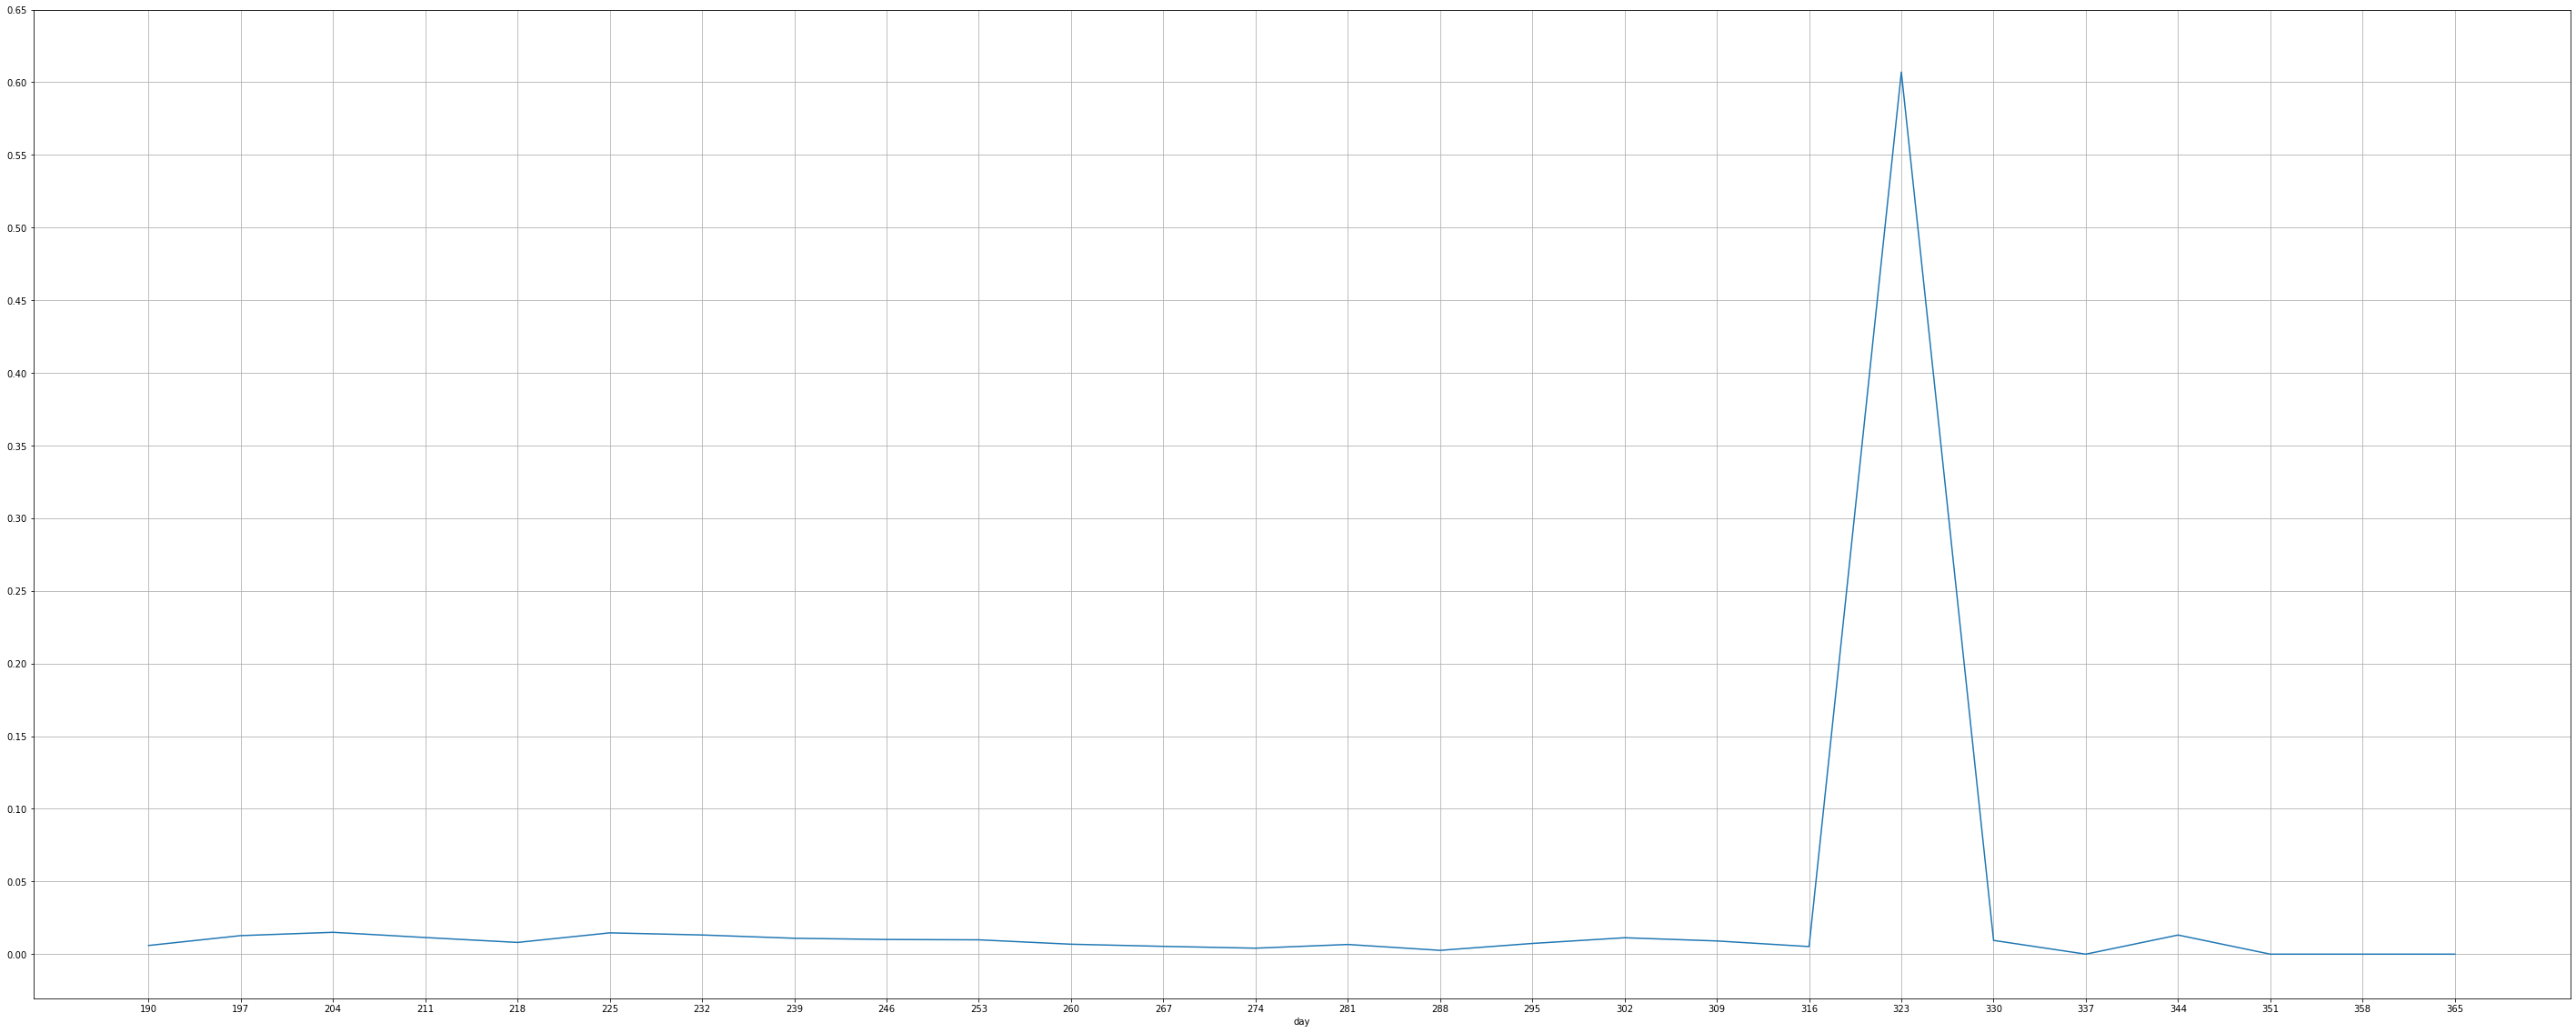

In [25]:
plt.figure(figsize=(50, 20))
train_df5.groupby(['day'])['target'].apply(lambda x: sum(x) / len(x)).plot()
plt.xticks(train_df5['day'].unique())
plt.yticks(np.arange(0, 0.7, 0.05))
plt.grid()
plt.show()

Выброс с 317 по 344 день.

# Разбиение на  train  и  test

In [26]:
TARGET_NAME = 'target'

In [27]:
X_train = train_df5.drop(columns=[TARGET_NAME])
y_train = train_df5[TARGET_NAME]
X_test = test_df5.drop(columns=[TARGET_NAME])
y_test = test_df5[TARGET_NAME]

display(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))

0.0    0.981736
1.0    0.018264
Name: target, dtype: float64

0.0    0.982438
1.0    0.017562
Name: target, dtype: float64

In [28]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0.0    55472
1.0    54696
Name: target, dtype: int64

In [29]:
X_train_balanced = df_balanced.drop(columns=TARGET_NAME)
y_train_balanced = df_balanced[TARGET_NAME]

# Поиск категориальных признаков среди вещественных

In [30]:
df_numerical = X_train.select_dtypes(include = [np.number])
df_categorical = X_train.select_dtypes(exclude = [np.number])

In [31]:
# Ищу признаки категориальные среди вещественных
select_spy = pd.DataFrame(df_numerical.nunique())

In [32]:
list_spy = select_spy.loc[select_spy[0] < 11].index.to_list()

In [33]:
list_spy.remove('vas_id')

In [34]:
#df_categorical = df_all[list_spy]

In [35]:
#df_numerical.drop(labels=list_spy, axis=1, inplace = True)
#вырезаем эти колонки из количественных данных

In [36]:
#df_numerical.drop(labels=['target'], axis=1, inplace = True)

In [37]:
# где у нас нули
#for i in df_numerical.columns:
#    print(i, df4[i][df4[i]==0].count())

In [38]:
# Проверка
Categorical_features = X_train_balanced.select_dtypes(exclude=[np.number])

In [39]:
cat_feats = Categorical_features.columns.to_list()

In [40]:
cat_feats

[]

In [41]:
#df4[list_spy] = df4[list_spy].astype('object')

In [42]:
#categorical_features = df4.select_dtypes(include=['object']).columns.to_list()

In [43]:
list_spy = ['15', '16', '17', '23', '24', '26', '27', '29', '30', '31', '32', '33', '35', '57',
     '65', '75', '81', '85', '95', '131', '132', '139', '154', '155', '179', '192', '194', '195',
     '196', '197', '198', '199', '200', '201', '202', '203', '204', '205', '206', '212', '216',
     '218', '220', '221', '252', 'month']

# Выбор модели

In [58]:
disbalance = y_train.value_counts()[0] / y_train.value_counts()[1]
disbalance

53.751937984496124

In [63]:
disbalance2 = y_train_balanced.value_counts()[0] / y_train_balanced.value_counts()[1]
disbalance2

1.0141875091414363

scale_pos_weight не помог

# XGBClassifier

In [44]:
# manually handling imbalance. Below is same as computing float(18501)/392318 
#on the trainig dataset.
# We are going to inversely assign the weights
weight_ratio = float(len(y_train_balanced[y_train_balanced == 0]))/float(len(y_train_balanced[y_train_balanced == 1]))
w_array = np.array([1]*y_train_balanced.shape[0])
w_array[y_train_balanced==1] = weight_ratio
w_array[y_train_balanced==0] = 1- weight_ratio

sample_weight=w_array не повлиял на результат

In [45]:
model_xgb = xgb.XGBClassifier(random_state=21)

In [46]:
feature_importances = train_evaluate_preds(model_xgb, X_train, X_test, y_train, y_test)

0.0    0.981736
1.0    0.018264
Name: target, dtype: float64

0.0    0.982438
1.0    0.017562
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:14:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     55472
         1.0       1.00      0.96      0.98      1032

    accuracy                           1.00     56504
   macro avg       1.00      0.98      0.99     56504
weighted avg       1.00      1.00      1.00     56504

TEST

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     36921
         1.0       0.72      0.54      0.61       660

    accuracy                           0.99     37581
   macro avg       0.85      0.77      0.80     37581
weighted avg       0.99      0.99      0.99     37581

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     36780  141
1.0       305  355


macro avg       0.88      0.65      0.71     87015

Подобрал learning_rate от переобучения

In [47]:
model_xgb = xgb.XGBClassifier(random_state=21)

In [48]:
feature_importances = train_evaluate_preds(model_xgb, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.503522
1.0    0.496478
Name: target, dtype: float64

0.0    0.982438
1.0    0.017562
Name: target, dtype: float64

/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:15:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/jb/anaconda3/lib/python3.8/site-packages/xgboost/data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     55472
         1.0       1.00      1.00      1.00     54696

    accuracy                           1.00    110168
   macro avg       1.00      1.00      1.00    110168
weighted avg       1.00      1.00      1.00    110168

TEST

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     36921
         1.0       0.61      0.67      0.64       660

    accuracy                           0.99     37581
   macro avg       0.80      0.83      0.82     37581
weighted avg       0.99      0.99      0.99     37581

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     36638  283
1.0       215  445


macro avg       0.77      0.87      0.81     28204

Для оценки качества модели будем использовать кросс-валидацию по 3-ем фолдам.

# LGBMClassifier

In [51]:
model_lgbm = LGBMClassifier(random_state=21)

Регуляризация не повлияла на результат

In [52]:
feature_importances = train_evaluate_preds(model_lgbm, X_train, X_test, y_train, y_test)

0.0    0.981736
1.0    0.018264
Name: target, dtype: float64

0.0    0.982438
1.0    0.017562
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     55472
         1.0       1.00      0.91      0.95      1032

    accuracy                           1.00     56504
   macro avg       1.00      0.95      0.97     56504
weighted avg       1.00      1.00      1.00     56504

TEST

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99     36921
         1.0       0.70      0.57      0.63       660

    accuracy                           0.99     37581
   macro avg       0.85      0.78      0.81     37581
weighted avg       0.99      0.99      0.99     37581

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     36764  157
1.0       287  373


 macro avg       0.87      0.65      0.71     75129

In [54]:
model_lgbm = LGBMClassifier(random_state=21)

In [55]:
feature_importances = train_evaluate_preds(model_lgbm, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.503522
1.0    0.496478
Name: target, dtype: float64

0.0    0.982438
1.0    0.017562
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     55472
         1.0       0.99      1.00      0.99     54696

    accuracy                           0.99    110168
   macro avg       0.99      0.99      0.99    110168
weighted avg       0.99      0.99      0.99    110168

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     36921
         1.0       0.53      0.78      0.63       660

    accuracy                           0.98     37581
   macro avg       0.76      0.88      0.81     37581
weighted avg       0.99      0.98      0.99     37581

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     36468  453
1.0       148  512


macro avg       0.78      0.87      0.82     28204

# CatBoostClassifier

In [59]:
frozen_params = {
     'class_weights':[1, disbalance], 
     'silent':True,
     'random_state':21,
     #'cat_features': ['month', 'clasters_3', 'clasters_7'],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [60]:
model_catb = catb.CatBoostClassifier(**frozen_params)

In [61]:
feature_importances = train_evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

0.0    0.981736
1.0    0.018264
Name: target, dtype: float64

0.0    0.982438
1.0    0.017562
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     55472
         1.0       0.70      1.00      0.82      1032

    accuracy                           0.99     56504
   macro avg       0.85      1.00      0.91     56504
weighted avg       0.99      0.99      0.99     56504

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     36921
         1.0       0.57      0.75      0.65       660

    accuracy                           0.99     37581
   macro avg       0.78      0.87      0.82     37581
weighted avg       0.99      0.99      0.99     37581

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     36541  380
1.0       162  498


macro avg       0.76      0.83      0.79     75129

In [64]:
frozen_params2 = {
     'class_weights':[1, disbalance2], 
     'silent':True,
     'random_state':21,
     #'cat_features': ['month', 'clasters_3', 'clasters_7'],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [65]:
model_catb2 = catb.CatBoostClassifier(**frozen_params2)

In [66]:
feature_importances = train_evaluate_preds(model_catb2, X_train_balanced, X_test, y_train_balanced, y_test)

0.0    0.503522
1.0    0.496478
Name: target, dtype: float64

0.0    0.982438
1.0    0.017562
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     55472
         1.0       1.00      1.00      1.00     54696

    accuracy                           1.00    110168
   macro avg       1.00      1.00      1.00    110168
weighted avg       1.00      1.00      1.00    110168

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     36921
         1.0       0.60      0.74      0.66       660

    accuracy                           0.99     37581
   macro avg       0.80      0.87      0.83     37581
weighted avg       0.99      0.99      0.99     37581

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     36587  334
1.0       169  491


macro avg       0.78      0.87      0.81     28204

По результатам отборочных туров, главным тренером команды назначен CatBoostClassifier на несбалансированных данных.

# Выбор метода балансировки датасета

In [76]:
#df_balanced_tomek = balance_df_by_target_advance(df_for_balancing, 'target', method='tomek')

In [77]:
#X_train_tomek = df_balanced_tomek.drop(columns=TARGET_NAME)
#y_train_tomek = df_balanced_tomek[TARGET_NAME]

In [78]:
#disbalance_t = y_train_tomek.value_counts()[0] / y_train_tomek.value_counts()[1]
#disbalance_t

In [79]:
#frozen_params_t = {
 #    'class_weights':[1, disbalance_t], 
  #   'silent':True,
   #  'random_state':21,
    # 'eval_metric':'F1',
    # 'early_stopping_rounds':60
#}

In [80]:
#model_catb_t = catb.CatBoostClassifier(**frozen_params_t, reg_lambda = 0.1)

In [81]:
#feature_importances = train_evaluate_preds(model_catb_t, X_train_tomek, X_test, y_train_tomek, y_test)

In [82]:
#df_smote = balance_df_by_target_advance(df_for_balancing, 'target', method='smote')

In [83]:
#X_train_smote= df_smote.drop(columns=TARGET_NAME)
#y_train_smote = df_smote[TARGET_NAME]

In [84]:
#disbalance_s = y_train_smote.value_counts()[0] / y_train_smote.value_counts()[1]
#disbalance_s

In [85]:
#frozen_params_s = {
#     'class_weights':[1, disbalance_s], 
#     'silent':True,
#     'random_state':21,
#     'eval_metric':'F1',
#     'early_stopping_rounds':60
#}

In [86]:
#model_catb_s = catb.CatBoostClassifier(**frozen_params_s, reg_lambda = 0.1)

In [87]:
#feature_importances = train_evaluate_preds(model_catb_s, X_train_smote, X_test, y_train_smote, y_test)

In [88]:
#run_cv(model_catb_s, kfold_cv, X_train_smote, y_train_smote, model_name="model_catb");

In [89]:
#fea_imp = feature_importances[feature_importances['importance'] > 0]['feature_name'].to_list()

In [90]:
#feature_importances = train_evaluate_preds(model_catb_s, X_train_smote[fea_imp], X_test[fea_imp], y_train_smote, y_test)

In [91]:
#X_train = X_train_smote[fea_imp]
#X_test = X_test[fea_imp]
#y_train = y_train_smote

# Удаление признаков

In [92]:
feature_importances = train_evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

0.0    0.981736
1.0    0.018264
Name: target, dtype: float64

0.0    0.982438
1.0    0.017562
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     55472
         1.0       0.70      1.00      0.82      1032

    accuracy                           0.99     56504
   macro avg       0.85      1.00      0.91     56504
weighted avg       0.99      0.99      0.99     56504

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     36921
         1.0       0.57      0.75      0.65       660

    accuracy                           0.99     37581
   macro avg       0.78      0.87      0.82     37581
weighted avg       0.99      0.99      0.99     37581

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     36541  380
1.0       162  498


In [93]:
fea_imp = feature_importances[feature_importances['importance'] > 0]['feature_name'].to_list()

In [94]:
len(fea_imp)

235

In [95]:
X_train.shape

(56504, 272)

In [96]:
feature_importances = train_evaluate_preds(model_catb, X_train[fea_imp], X_test[fea_imp], y_train, y_test)

0.0    0.981736
1.0    0.018264
Name: target, dtype: float64

0.0    0.982438
1.0    0.017562
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     55472
         1.0       0.69      1.00      0.82      1032

    accuracy                           0.99     56504
   macro avg       0.85      1.00      0.91     56504
weighted avg       0.99      0.99      0.99     56504

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     36921
         1.0       0.58      0.76      0.66       660

    accuracy                           0.99     37581
   macro avg       0.79      0.88      0.83     37581
weighted avg       0.99      0.99      0.99     37581

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     36554  367
1.0       156  504


In [97]:
X_train = X_train[fea_imp]
X_test = X_test[fea_imp]

Чемпионат был длинный и часть игроков померла а часть еле дышит. Вызываю санитаров.

https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html

In [98]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

In [99]:
lr = LinearRegression()
#select 10 the most informative features
rfe = RFE(lr)
selector = rfe.fit(X_train, y_train)

In [100]:
selector.ranking_

array([112,   1,   1, 102,   1,  62,   1,  64,   1,  86,   1,  87,   1,
         1,   1, 108,   1,   1,   1,   1,  45,  44,  37,  31,   1,   1,
         1,  54,  30,   1,  99,   1,   1,   1,   1,  79,   1,   1,   1,
         1,  80,  91, 110,   1,   1,  57,  96,   1,  56,  23,  47,  46,
         1,   1,   1,   1,   1,  20,   1,   1,   1,   1,   1,   1,   1,
         1,  29,  19,  60,   1,   1,   1,  25,  85,  42,  12,  69,  68,
        15,  16,  74,   1,  52,  17,  98,  82,   7,   5,  75,  18,  61,
        70,  24,  38,  11,   1,  13,   1,   1,   6,   1,   1,  95,   1,
         1,  63,   1,   1,   1,   1,   1,   1,   1,   1,   3,   1,  97,
         1,  93,   1,   8,   1,   1,  26,   1,   1,   1,  71,  27,  55,
        53,   1,   1,   1,   1,   1,   1,   1,   1,   1,  88,   1,  94,
         1,   1,   1,   9,  73,  22,  59,  50,  14,  49,  51,   1,   1,
         1,   1,   1,  10,   1,   1,   1,   1,  21,   1,  43,   1,   1,
         1, 104,   1,   1,   1,   1,   1,   1,   1,   1,   1,   

In [101]:
value = np.array(X_train.columns.to_list())
mask = selector.support_
last_col = list(value[mask])
last_col.extend(['id'])
X_train_short = X_train[last_col]

In [102]:
X_test_short = X_test[last_col]

In [103]:
feature_importances = train_evaluate_preds(model_catb, X_train_short, X_test_short, y_train, y_test)

0.0    0.981736
1.0    0.018264
Name: target, dtype: float64

0.0    0.982438
1.0    0.017562
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     55472
         1.0       0.67      1.00      0.81      1032

    accuracy                           0.99     56504
   macro avg       0.84      1.00      0.90     56504
weighted avg       0.99      0.99      0.99     56504

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     36921
         1.0       0.56      0.77      0.65       660

    accuracy                           0.99     37581
   macro avg       0.78      0.88      0.82     37581
weighted avg       0.99      0.99      0.99     37581

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     36521  400
1.0       153  507


In [104]:
feature_importances = train_evaluate_preds(model_catb, X_train, X_test, y_train, y_test)

0.0    0.981736
1.0    0.018264
Name: target, dtype: float64

0.0    0.982438
1.0    0.017562
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     55472
         1.0       0.69      1.00      0.82      1032

    accuracy                           0.99     56504
   macro avg       0.85      1.00      0.91     56504
weighted avg       0.99      0.99      0.99     56504

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     36921
         1.0       0.58      0.76      0.66       660

    accuracy                           0.99     37581
   macro avg       0.79      0.88      0.83     37581
weighted avg       0.99      0.99      0.99     37581

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     36554  367
1.0       156  504


/home/jb/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


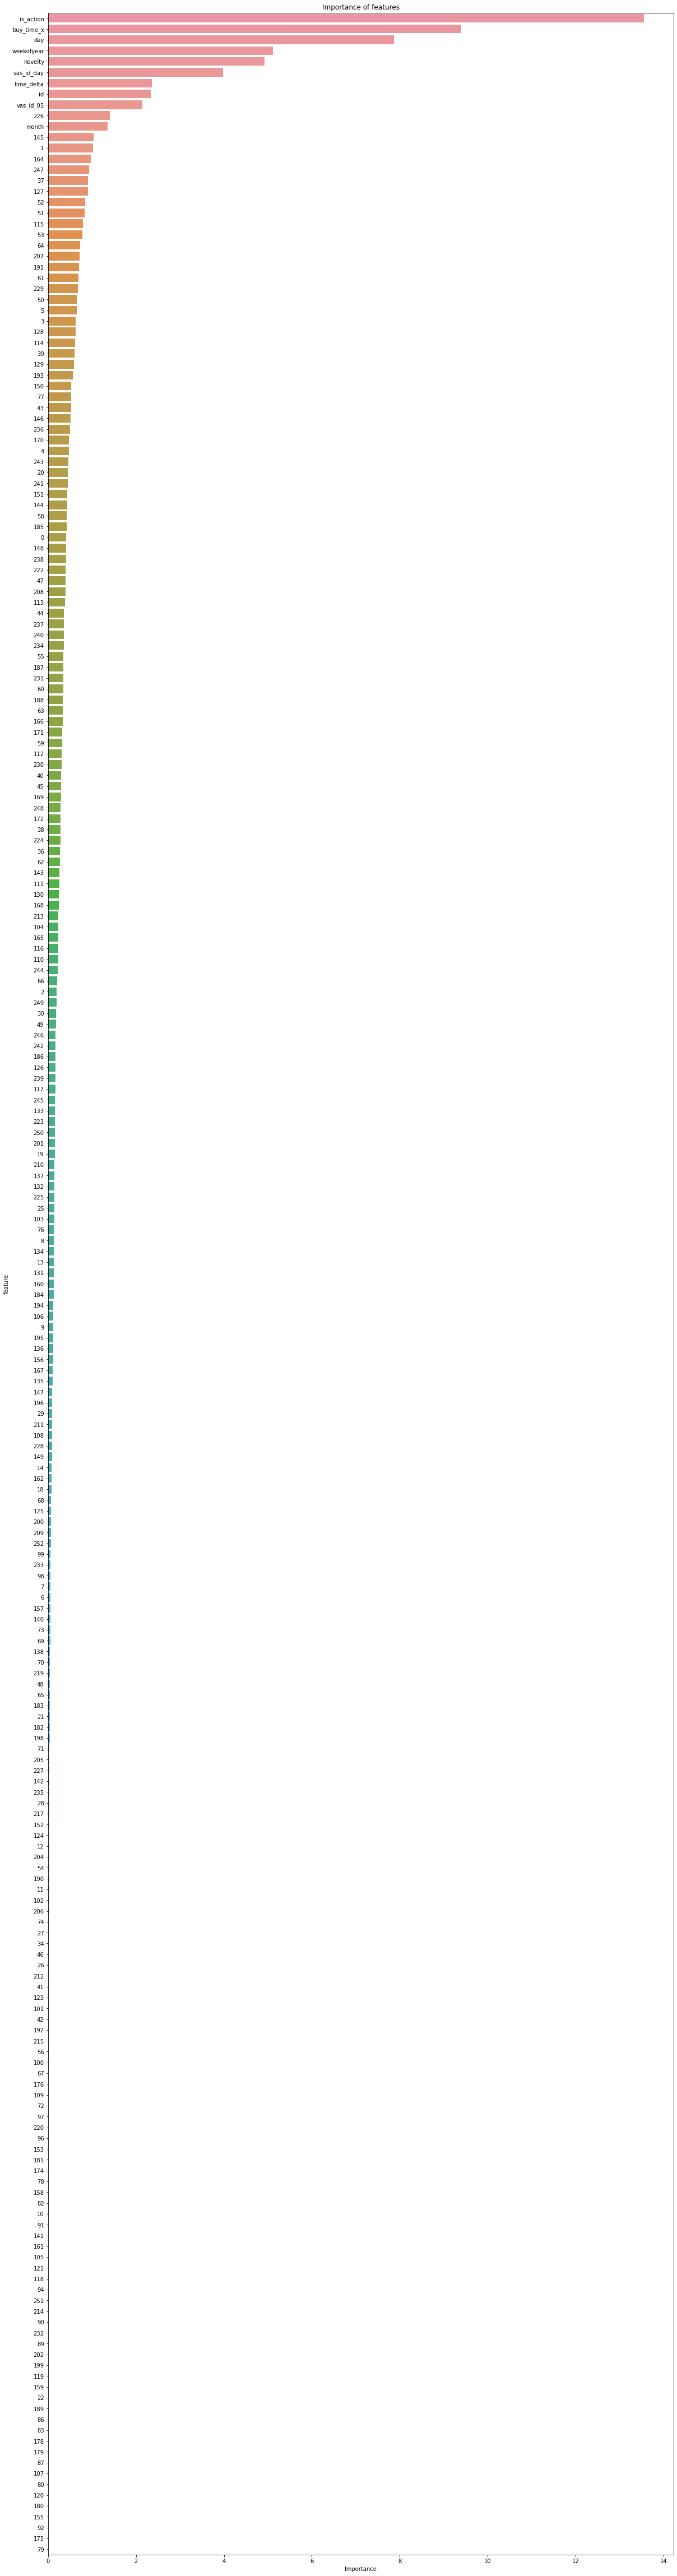

['is_action', 'buy_time_x', 'day', 'weekofyear', 'novelty']

In [105]:
show_feature_importances(feature_importances['feature_name'], feature_importances['importance'], get_top = 5)

# SHAP

In [106]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [107]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model_catb)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

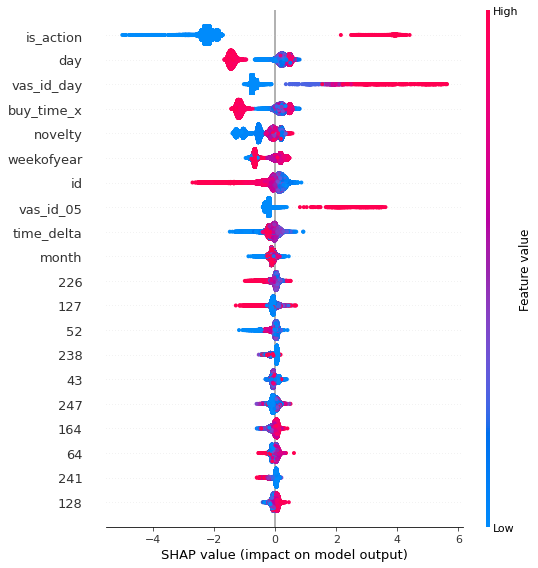

In [108]:
# summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

Как его читать:

    значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
    чем толще линия на графике, тем больше таких точек наблюдения
    чем краснее точка на графике, тем выше значения признака в ней


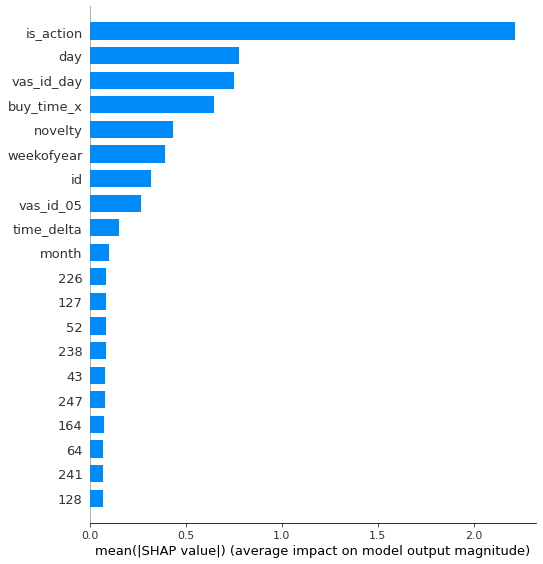

In [109]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [171]:
# Закладка
train_df5 = pd.concat([X_train, y_train], axis=1)
test_df5 = pd.concat([X_test, y_test], axis=1)
train_df5.to_csv('train_df5.csv', index=False)
test_df5.to_csv('test_df5.csv', index=False)

In [172]:
train_df5 = pd.read_csv('train_df5.csv')
test_df5 = pd.read_csv('test_df5.csv')
X_test = test_df5.drop(columns=['target'])
y_test = test_df5['target']
X_train = train_df5.drop(columns=['target'])
y_train = train_df5['target']

# Подбор гиперпараметров

In [118]:
from matplotlib import pyplot

Исследование количества деревьев


In [114]:
# get a list of models to evaluate
def get_models():
    models = dict()
    trees = [50, 100, 200, 500, 1000]
    for n in trees:
        models[str(n)] = catb.CatBoostClassifier(random_state = 21, iterations=n, silent = True)
    return models

In [115]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [116]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>50 0.793 (0.014)
>100 0.785 (0.010)
>200 0.788 (0.014)
>500 0.791 (0.018)
>1000 0.791 (0.018)


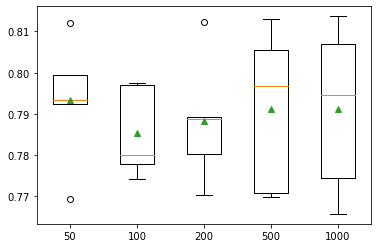

In [119]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Исследование глубины дерева


In [120]:
# get a list of models to evaluate
def get_models():
    models = dict()
    for i in range(1,7):
        models[str(i)] = catb.CatBoostClassifier(max_depth=i, num_leaves=2**i,
                                            random_state=21, silent = True)
    return models

In [121]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [122]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>1 0.801 (0.019)
>2 0.805 (0.012)
>3 0.796 (0.014)
>4 0.796 (0.015)
>5 0.792 (0.018)
>6 0.791 (0.018)


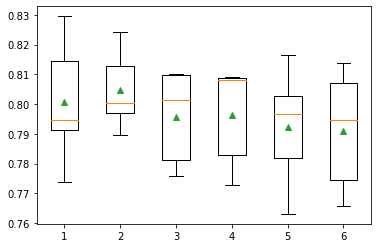

In [123]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Исследование скорости обучения

In [124]:
# get a list of models to evaluate
def get_models():
    models = dict()
    rates = [0.0001, 0.001, 0.01, 0.1, 1.0]
    for r in rates:
        key = '%.4f' % r
        models[key] = catb.CatBoostClassifier(learning_rate=r,
                                            random_state=21, silent = True)
    return models

In [125]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [126]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>0.0001 0.823 (0.008)
>0.0010 0.754 (0.025)
>0.0100 0.798 (0.014)
>0.1000 0.795 (0.017)
>1.0000 0.778 (0.014)


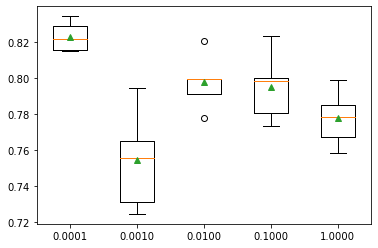

In [127]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

Исследование регуляризации

In [128]:
# get a list of models to evaluate
def get_models():
    models = dict()
    types = [0.1,1,2,4,8]
    for t in types:
        models[t] = catb.CatBoostClassifier(l2_leaf_reg=t,
                                            random_state=21, silent=True)
    return models

In [129]:
# evaluate a give model using cross-validation
def evaluate_model(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=21)
    scores = cross_val_score(model, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
    return scores

In [130]:
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, scores.mean(), scores.std()))

>0.1 0.788 (0.017)
>1 0.794 (0.015)
>2 0.793 (0.015)
>4 0.794 (0.010)
>8 0.795 (0.009)


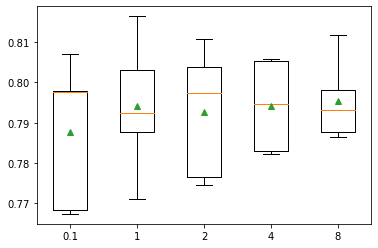

In [131]:
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [132]:
params = {'n_estimators':[25, 50, 500],
          'max_depth':[2, 3, 4]}

In [133]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [134]:
model_catb = catb.CatBoostClassifier(**frozen_params)

In [135]:
%%time

grid_search = model_catb.randomized_search(params, X_train, y_train, n_iter = 50, cv = cv, stratified = True, plot = True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8183237144
bestIteration = 17

0:	loss: 0.8183237	best: 0.8183237 (0)	total: 997ms	remaining: 7.98s

bestTest = 0.883385122
bestIteration = 48

1:	loss: 0.8833851	best: 0.8833851 (1)	total: 2.42s	remaining: 8.46s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.883385122
bestIteration = 48

2:	loss: 0.8833851	best: 0.8833851 (1)	total: 5.13s	remaining: 10.3s

bestTest = 0.8709856713
bestIteration = 24

3:	loss: 0.8709857	best: 0.8833851 (1)	total: 5.87s	remaining: 7.34s

bestTest = 0.883752302
bestIteration = 33

4:	loss: 0.8837523	best: 0.8837523 (4)	total: 7.32s	remaining: 5.86s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.883752302
bestIteration = 33

5:	loss: 0.8837523	best: 0.8837523 (4)	total: 10.3s	remaining: 5.17s

bestTest = 0.8740655899
bestIteration = 22

6:	loss: 0.8740656	best: 0.8837523 (4)	total: 11.8s	remaining: 3.38s

bestTest = 0.8837931186
bestIteration = 27

7:	loss: 0.8837931	best: 0.8837931 (7)	total: 13.6s	r

In [137]:
best_model = catb.CatBoostClassifier(**frozen_params, n_estimators = 500)

In [138]:
best_model.fit(X_train, y_train)

In [139]:
evaluate_preds(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     55472
         1.0       0.69      1.00      0.82      1032

    accuracy                           0.99     56504
   macro avg       0.84      1.00      0.91     56504
weighted avg       0.99      0.99      0.99     56504

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     36921
         1.0       0.57      0.77      0.65       660

    accuracy                           0.99     37581
   macro avg       0.78      0.88      0.82     37581
weighted avg       0.99      0.99      0.99     37581

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     36539  382
1.0       155  505


In [140]:
best_model = catb.CatBoostClassifier(**frozen_params, n_estimators=50, max_depth=2)

In [141]:
feature_importances = train_evaluate_preds(best_model, X_train, X_test, y_train, y_test)

0.0    0.981736
1.0    0.018264
Name: target, dtype: float64

0.0    0.982438
1.0    0.017562
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     55472
         1.0       0.39      0.85      0.53      1032

    accuracy                           0.97     56504
   macro avg       0.69      0.91      0.76     56504
weighted avg       0.99      0.97      0.98     56504

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.97      0.99     36921
         1.0       0.36      0.84      0.51       660

    accuracy                           0.97     37581
   macro avg       0.68      0.91      0.75     37581
weighted avg       0.99      0.97      0.98     37581

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     35948  973
1.0       106  554


Не выходит каменный цветок.

# Снижение степени переобучения

In [142]:
params = {'l2_leaf_reg': [0.1, 2, 3, 4],
         'learning_rate': [0.0001, 0.01, 0.1]
         }

In [143]:
model = catb.CatBoostClassifier(**frozen_params)

In [144]:
grid_search = model.randomized_search(params, X_train, y_train, n_iter = 50, cv = cv, stratified = True, plot = True, refit=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.8216763137
bestIteration = 2

0:	loss: 0.8216763	best: 0.8216763 (0)	total: 3.74s	remaining: 41.1s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.8844875785
bestIteration = 79

1:	loss: 0.8844876	best: 0.8844876 (1)	total: 11.2s	remaining: 56.2s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.8865164695
bestIteration = 30

2:	loss: 0.8865165	best: 0.8865165 (2)	total: 16.1s	remaining: 48.3s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.8216763137
bestIteration = 2

3:	loss: 0.8216763	best: 0.8865165 (2)	total: 19.3s	remaining: 38.7s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.8835482754
bestIteration = 146

4:	loss: 0.8835483	best: 0.8865165 (2)	total: 29.8s	remaining: 41.7s
Stopped by overfitting detector  (60 iterations wait)

bestTest = 0.8840789406
bestIteration = 44

5:	loss: 0.8840789	best: 0.8865165 (2)	total: 35.2s	remaining:

Поисковые сетки ничего не знают о требованиях Мегафона к average: macro, и ищут взвешенные метрики. Придется обломиться с поиском.

In [145]:
best_model = catb.CatBoostClassifier(**frozen_params,  learning_rate = 0.0001)

In [146]:
feature_importances = train_evaluate_preds(best_model, X_train, X_test, y_train, y_test)

0.0    0.981736
1.0    0.018264
Name: target, dtype: float64

0.0    0.982438
1.0    0.017562
Name: target, dtype: float64

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     55472
         1.0       0.59      0.75      0.66      1032

    accuracy                           0.99     56504
   macro avg       0.79      0.87      0.83     56504
weighted avg       0.99      0.99      0.99     56504

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     36921
         1.0       0.60      0.76      0.67       660

    accuracy                           0.99     37581
   macro avg       0.80      0.88      0.83     37581
weighted avg       0.99      0.99      0.99     37581

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     36591  330
1.0       156  504


In [147]:
run_cv(best_model, kfold_cv, X_train, y_train, model_name="best_model");

best_model: f1_macro = 0.82 (+/- 0.01)


# Подбор порога

In [148]:
#наши прогнозы для тестовой выборки
preds = best_model.predict_proba(X_test)[:, 1]
preds[:10]

array([0.38920732, 0.39237051, 0.4776677 , 0.47255845, 0.47585938,
       0.4809701 , 0.47805897, 0.3886467 , 0.47936225, 0.38688615])

In [149]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.496583, F-Score=0.676, Precision=0.601, Recall=0.773


In [150]:
def predict_proba_to_int(y_predicted_probs, threshold):
         return (y_predicted_probs > threshold)*1

In [151]:
# Нашли метки предсказания для лучшего порога
best_predict = predict_proba_to_int(preds, thresholds[ix])

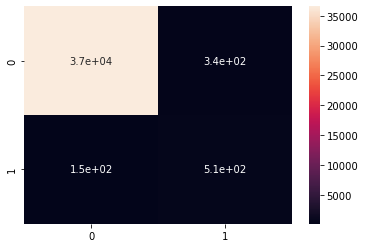

In [152]:
sns.heatmap(confusion_matrix(y_test, best_predict), annot=True)
plt.show()

Модернизирую функцию evaluate_preds для получения скоров с учетом лучшего вероятностного порога.

In [153]:
def evaluate_preds_with_threshold(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_poba = model.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test,\
                                                           y_test_poba)
    fscore = (2 * precision * recall) / (precision + recall)
    # locate the index of the largest f score
    ix = np.argmax(fscore)
    best_predict = predict_proba_to_int(y_test_poba, thresholds[ix])
    

    get_classification_report(y_train, y_train_pred, y_test, best_predict)
    print('Best Threshold=%f' % (thresholds[ix]))
    
    return best_predict

In [154]:
evaluate_preds(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     55472
         1.0       0.59      0.75      0.66      1032

    accuracy                           0.99     56504
   macro avg       0.79      0.87      0.83     56504
weighted avg       0.99      0.99      0.99     56504

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     36921
         1.0       0.60      0.76      0.67       660

    accuracy                           0.99     37581
   macro avg       0.80      0.88      0.83     37581
weighted avg       0.99      0.99      0.99     37581

CONFUSION MATRIX

col_0     0.0  1.0
target            
0.0     36591  330
1.0       156  504


In [155]:
best_predict = evaluate_preds_with_threshold(best_model, X_train, X_test, y_train, y_test)

TRAIN

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     55472
         1.0       0.59      0.75      0.66      1032

    accuracy                           0.99     56504
   macro avg       0.79      0.87      0.83     56504
weighted avg       0.99      0.99      0.99     56504

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     36921
         1.0       0.60      0.77      0.68       660

    accuracy                           0.99     37581
   macro avg       0.80      0.88      0.83     37581
weighted avg       0.99      0.99      0.99     37581

CONFUSION MATRIX

col_0       0    1
target            
0.0     36583  338
1.0       151  509
Best Threshold=0.496583


Удалось повысить на 1% метрику и снизить на 1% переобучение.

Написал функцию для тонкой настройки трешхолда

In [156]:
def predict_proba_compare(model, X_test, X_train, y_test, y_train, cut_off):
    # функция изменения линии отсечки при расчете таргета
    pred_proba_test = model.predict_proba(X_test)
    y_test_proba=np.where(pred_proba_test[:, 1] > cut_off, 1, 0)
    pred_proba_train = model.predict_proba(X_train)
    y_train_proba=np.where(pred_proba_train[:, 1] > cut_off, 1, 0)
    print('TRAIN\n\n' + classification_report(y_train, y_train_proba))
    print('TEST\n\n' + classification_report(y_test, y_test_proba))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test, y_test_proba))
    
    return y_train_proba, y_test_proba

In [157]:
predict_proba_compare(best_model, X_test, X_train, y_test, y_train, 0.54)

TRAIN

              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99     55472
         1.0       0.61      0.71      0.65      1032

    accuracy                           0.99     56504
   macro avg       0.80      0.85      0.82     56504
weighted avg       0.99      0.99      0.99     56504

TEST

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99     36921
         1.0       0.62      0.74      0.67       660

    accuracy                           0.99     37581
   macro avg       0.81      0.87      0.83     37581
weighted avg       0.99      0.99      0.99     37581

CONFUSION MATRIX

col_0       0    1
target            
0.0     36617  304
1.0       172  488


(array([0, 0, 0, ..., 0, 0, 0]), array([0, 0, 0, ..., 0, 0, 0]))

убрал переобучение, таким образом беру трешхолд 0,54

С трешхолдом нет смысла возиться.

In [158]:
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          model_name="",
                          normalize=False,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest',  cmap=cmap)
    
    plt.grid(False)
    plt.title('%s: confusion matrix' % model_name)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [159]:
y_test_poba = best_model.predict_proba(X_test)[:, 1]

Confusion matrix, without normalization
[[36591   330]
 [  156   504]]


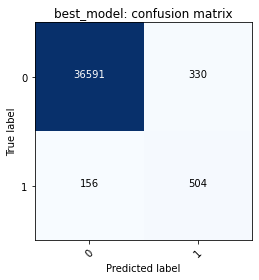

In [160]:
cm = confusion_matrix(y_test, y_test_poba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");

# СОЗДАЮ ПАЙПЛАЙН

На несбалансированных данных!


In [6]:
columns5 = ['id', 'buy_time_x', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
      '10', '11', '12', '13', '14', '18', '19', '20', '21', '22', '25', '26', '27',
      '28', '29', '30', '34', '36', '37', '38', '39', '40', '41', '42', '43', '44',
      '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55','56',
      '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70',
      '71', '72', '73', '74', '76', '77', '78', '79', '80', '82', '83', '86', '87',
      '89', '90', '91', '92', '94', '96', '97', '98', '99', '100', '101', '102', '103',
      '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114',
      '115', '116', '117', '118', '119', '120', '121', '123', '124', '125', '126',
      '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137',
      '138', '140', '141', '142', '143', '144', '145', '146', '147', '148', '149', '150',
      '151', '152', '153', '155', '156', '157', '158', '159', '160', '161', '162', '164',
      '165', '166', '167', '168', '169', '170', '171', '172', '174', '175', '176',
      '178', '179', '180', '181', '182', '183', '184', '185', '186', '187', '188',
      '189', '190', '191', '192', '193', '194', '195', '196', '198', '199', '200',
      '201', '202', '204', '205', '206', '207', '208', '209', '210', '211', '212',
      '213', '214', '215', '217', '219', '220', '222', '223', '224', '225', '226',
      '227', '228', '229', '230', '231', '232', '233', '234', '235', '236', '237',
      '238', '239', '240', '241', '242', '243', '244', '245', '246', '247', '248',
      '249', '250', '251', '252', 'time_delta', 'vas_id_05', 'month', 'day',
      'weekofyear', 'novelty', 'vas_id_day', 'is_action']

In [7]:
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

In [8]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [9]:
Selected_Columns = Pipeline([
                ('selector', ColumnSelector(columns5))
            ])

In [10]:
pipeline = Pipeline([
    ('Selected_Columns', Selected_Columns),
    ('classifier', catb.CatBoostClassifier(class_weights = [1, 53.75], random_state = 21, eval_metric = 'F1', learning_rate = 0.0001))
])

# Сохранение модели

In [4]:
import pickle

In [12]:
with open('model_5.pkl', 'wb') as model:
    pickle.dump(pipeline, model)

In [168]:
with open('model_5.pkl', 'rb') as model:
    x = pickle.load(model)

In [169]:
x.fit(X_test, y_test)

0:	learn: 0.8460062	total: 60.5ms	remaining: 1m
1:	learn: 0.8460062	total: 110ms	remaining: 54.8s
2:	learn: 0.8460062	total: 155ms	remaining: 51.7s
3:	learn: 0.8518403	total: 196ms	remaining: 48.8s
4:	learn: 0.8833402	total: 236ms	remaining: 47s
5:	learn: 0.8840098	total: 290ms	remaining: 48s
6:	learn: 0.8838318	total: 333ms	remaining: 47.3s
7:	learn: 0.8837908	total: 390ms	remaining: 48.4s
8:	learn: 0.8838045	total: 435ms	remaining: 47.9s
9:	learn: 0.8837908	total: 478ms	remaining: 47.3s
10:	learn: 0.8838318	total: 531ms	remaining: 47.7s
11:	learn: 0.8839413	total: 586ms	remaining: 48.2s
12:	learn: 0.8840508	total: 639ms	remaining: 48.5s
13:	learn: 0.8841741	total: 692ms	remaining: 48.7s
14:	learn: 0.8845851	total: 748ms	remaining: 49.1s
15:	learn: 0.8824901	total: 792ms	remaining: 48.7s
16:	learn: 0.8811407	total: 834ms	remaining: 48.2s
17:	learn: 0.8651500	total: 877ms	remaining: 47.9s
18:	learn: 0.8826274	total: 920ms	remaining: 47.5s
19:	learn: 0.8844207	total: 985ms	remaining: 48

162:	learn: 0.8849554	total: 7.79s	remaining: 40s
163:	learn: 0.8850103	total: 7.83s	remaining: 39.9s
164:	learn: 0.8850652	total: 7.88s	remaining: 39.9s
165:	learn: 0.8852299	total: 7.92s	remaining: 39.8s
166:	learn: 0.8850652	total: 7.96s	remaining: 39.7s
167:	learn: 0.8849143	total: 8.01s	remaining: 39.7s
168:	learn: 0.8850240	total: 8.05s	remaining: 39.6s
169:	learn: 0.8848182	total: 8.1s	remaining: 39.5s
170:	learn: 0.8849828	total: 8.14s	remaining: 39.5s
171:	learn: 0.8850652	total: 8.19s	remaining: 39.4s
172:	learn: 0.8852162	total: 8.26s	remaining: 39.5s
173:	learn: 0.8853123	total: 8.35s	remaining: 39.6s
174:	learn: 0.8854221	total: 8.42s	remaining: 39.7s
175:	learn: 0.8855183	total: 8.49s	remaining: 39.8s
176:	learn: 0.8853123	total: 8.56s	remaining: 39.8s
177:	learn: 0.8854084	total: 8.62s	remaining: 39.8s
178:	learn: 0.8851887	total: 8.67s	remaining: 39.8s
179:	learn: 0.8850240	total: 8.73s	remaining: 39.8s
180:	learn: 0.8849417	total: 8.78s	remaining: 39.7s
181:	learn: 0.8

325:	learn: 0.8842974	total: 16.5s	remaining: 34.1s
326:	learn: 0.8843522	total: 16.6s	remaining: 34.1s
327:	learn: 0.8843248	total: 16.6s	remaining: 34s
328:	learn: 0.8843385	total: 16.6s	remaining: 33.9s
329:	learn: 0.8843522	total: 16.7s	remaining: 33.9s
330:	learn: 0.8843522	total: 16.8s	remaining: 33.9s
331:	learn: 0.8843248	total: 16.8s	remaining: 33.8s
332:	learn: 0.8843522	total: 16.9s	remaining: 33.8s
333:	learn: 0.8843248	total: 16.9s	remaining: 33.7s
334:	learn: 0.8842974	total: 17s	remaining: 33.7s
335:	learn: 0.8843111	total: 17s	remaining: 33.6s
336:	learn: 0.8842974	total: 17.1s	remaining: 33.6s
337:	learn: 0.8842837	total: 17.1s	remaining: 33.5s
338:	learn: 0.8842837	total: 17.2s	remaining: 33.5s
339:	learn: 0.8842837	total: 17.2s	remaining: 33.5s
340:	learn: 0.8842426	total: 17.3s	remaining: 33.4s
341:	learn: 0.8842563	total: 17.3s	remaining: 33.3s
342:	learn: 0.8842426	total: 17.4s	remaining: 33.3s
343:	learn: 0.8842426	total: 17.4s	remaining: 33.2s
344:	learn: 0.8842

484:	learn: 0.8840782	total: 24.3s	remaining: 25.8s
485:	learn: 0.8840782	total: 24.3s	remaining: 25.7s
486:	learn: 0.8840645	total: 24.4s	remaining: 25.7s
487:	learn: 0.8840782	total: 24.4s	remaining: 25.6s
488:	learn: 0.8840919	total: 24.5s	remaining: 25.6s
489:	learn: 0.8840919	total: 24.6s	remaining: 25.6s
490:	learn: 0.8840782	total: 24.6s	remaining: 25.5s
491:	learn: 0.8840919	total: 24.7s	remaining: 25.5s
492:	learn: 0.8840782	total: 24.7s	remaining: 25.4s
493:	learn: 0.8840919	total: 24.8s	remaining: 25.4s
494:	learn: 0.8840919	total: 24.8s	remaining: 25.3s
495:	learn: 0.8840782	total: 24.9s	remaining: 25.3s
496:	learn: 0.8840645	total: 24.9s	remaining: 25.2s
497:	learn: 0.8840372	total: 25s	remaining: 25.2s
498:	learn: 0.8840372	total: 25s	remaining: 25.1s
499:	learn: 0.8840372	total: 25.1s	remaining: 25.1s
500:	learn: 0.8840372	total: 25.1s	remaining: 25s
501:	learn: 0.8840372	total: 25.2s	remaining: 25s
502:	learn: 0.8840372	total: 25.2s	remaining: 24.9s
503:	learn: 0.884050

643:	learn: 0.8839140	total: 31.6s	remaining: 17.5s
644:	learn: 0.8839276	total: 31.6s	remaining: 17.4s
645:	learn: 0.8839413	total: 31.7s	remaining: 17.4s
646:	learn: 0.8839413	total: 31.7s	remaining: 17.3s
647:	learn: 0.8839550	total: 31.8s	remaining: 17.3s
648:	learn: 0.8839413	total: 31.8s	remaining: 17.2s
649:	learn: 0.8839550	total: 31.9s	remaining: 17.2s
650:	learn: 0.8839550	total: 31.9s	remaining: 17.1s
651:	learn: 0.8839550	total: 32s	remaining: 17.1s
652:	learn: 0.8839550	total: 32s	remaining: 17s
653:	learn: 0.8839413	total: 32.1s	remaining: 17s
654:	learn: 0.8839550	total: 32.1s	remaining: 16.9s
655:	learn: 0.8839550	total: 32.1s	remaining: 16.9s
656:	learn: 0.8839413	total: 32.2s	remaining: 16.8s
657:	learn: 0.8839276	total: 32.2s	remaining: 16.8s
658:	learn: 0.8839140	total: 32.3s	remaining: 16.7s
659:	learn: 0.8839140	total: 32.3s	remaining: 16.7s
660:	learn: 0.8839003	total: 32.4s	remaining: 16.6s
661:	learn: 0.8839003	total: 32.4s	remaining: 16.5s
662:	learn: 0.883900

803:	learn: 0.8838318	total: 39.2s	remaining: 9.55s
804:	learn: 0.8838318	total: 39.2s	remaining: 9.5s
805:	learn: 0.8838318	total: 39.3s	remaining: 9.45s
806:	learn: 0.8838318	total: 39.3s	remaining: 9.4s
807:	learn: 0.8838318	total: 39.4s	remaining: 9.36s
808:	learn: 0.8838318	total: 39.4s	remaining: 9.31s
809:	learn: 0.8838318	total: 39.5s	remaining: 9.26s
810:	learn: 0.8838318	total: 39.5s	remaining: 9.21s
811:	learn: 0.8838318	total: 39.6s	remaining: 9.16s
812:	learn: 0.8838318	total: 39.6s	remaining: 9.11s
813:	learn: 0.8838318	total: 39.7s	remaining: 9.06s
814:	learn: 0.8838318	total: 39.7s	remaining: 9.02s
815:	learn: 0.8838318	total: 39.8s	remaining: 8.97s
816:	learn: 0.8838318	total: 39.8s	remaining: 8.92s
817:	learn: 0.8838318	total: 39.9s	remaining: 8.87s
818:	learn: 0.8838318	total: 39.9s	remaining: 8.82s
819:	learn: 0.8838318	total: 40s	remaining: 8.77s
820:	learn: 0.8838318	total: 40s	remaining: 8.72s
821:	learn: 0.8838318	total: 40.1s	remaining: 8.68s
822:	learn: 0.8838

965:	learn: 0.8838318	total: 47.2s	remaining: 1.66s
966:	learn: 0.8838318	total: 47.2s	remaining: 1.61s
967:	learn: 0.8838318	total: 47.3s	remaining: 1.56s
968:	learn: 0.8838182	total: 47.3s	remaining: 1.51s
969:	learn: 0.8838318	total: 47.4s	remaining: 1.47s
970:	learn: 0.8838318	total: 47.5s	remaining: 1.42s
971:	learn: 0.8838182	total: 47.5s	remaining: 1.37s
972:	learn: 0.8838182	total: 47.5s	remaining: 1.32s
973:	learn: 0.8838182	total: 47.6s	remaining: 1.27s
974:	learn: 0.8838182	total: 47.6s	remaining: 1.22s
975:	learn: 0.8838182	total: 47.7s	remaining: 1.17s
976:	learn: 0.8838182	total: 47.7s	remaining: 1.12s
977:	learn: 0.8838182	total: 47.8s	remaining: 1.07s
978:	learn: 0.8838182	total: 47.9s	remaining: 1.03s
979:	learn: 0.8838182	total: 47.9s	remaining: 978ms
980:	learn: 0.8838182	total: 48s	remaining: 929ms
981:	learn: 0.8838182	total: 48s	remaining: 880ms
982:	learn: 0.8838182	total: 48.1s	remaining: 831ms
983:	learn: 0.8838182	total: 48.1s	remaining: 782ms
984:	learn: 0.88

Pipeline(steps=[('Selected_Columns',
                 Pipeline(steps=[('selector',
                                  ColumnSelector(key=['id', 'buy_time_x', '0',
                                                      '1', '2', '3', '4', '5',
                                                      '6', '7', '8', '9', '10',
                                                      '11', '12', '13', '14',
                                                      '18', '19', '20', '21',
                                                      '22', '25', '26', '27',
                                                      '28', '29', '30', '34',
                                                      '36', ...]))])),
                ('classifier',
                 <catboost.core.CatBoostClassifier object at 0x7f6de5c1fca0>)])

Confusion matrix, without normalization
[[36350   571]
 [  129   531]]


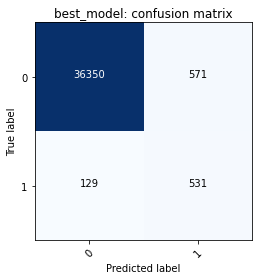

In [170]:
y_test_proba = x.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_test_proba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");

In [5]:
frozen_params = {
     'class_weights':[1, 53.75], 
     'silent':True,
     'random_state':21,
     #'cat_features': ['month', 'clasters_3', 'clasters_7'],
     'eval_metric':'F1',
     'early_stopping_rounds':60
}

In [6]:
best_model = catb.CatBoostClassifier(**frozen_params,  learning_rate = 0.0001)

In [7]:
with open('model5.pkl', 'wb') as model:
    pickle.dump(best_model, model)

In [ ]:
with open('model5.pkl', 'rb') as model:
    loaded_model = pickle.load(model)

In [ ]:
y_test_proba = loaded_model.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_test_proba > 0.5)
plot_confusion_matrix(cm, classes=["0", "1"], model_name="best_model");